Requirements:  numpy, pandas, seaborn, scikit-surprise

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Database

Dataframes:
- <b> ratings </b>: userId, movieId, rating, timestamp
- <b>movies</b>: movieId, title, genre
- <b>links</b>: movieId, imdbId, tmdbId
- <b>tags</b>: userId, movieId, tag, timestamp

## I. Load CSVs:

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

## II. Analyse shape of data

1. Avg + plot nb of ratings per user
2. Avg + plot nb of ratings per movie
3. Avg + plot nb of tags per movie


In [3]:
n_users = ratings['userId'].nunique()
n_movies = movies['movieId'].nunique()
print('{} users and {} movies'.format(n_users, n_movies))
print('Sparsity: {:.2f}%'.format((1- ratings['userId'].count()/(n_users*n_movies))*100))

610 users and 9742 movies
Sparsity: 98.30%


#### 1. Ratings per user

In [4]:
def group_count_sort(df, group_by, to_count):
    colName = to_count+" per "+group_by
    df_1 = pd.DataFrame(df.groupby(group_by)[to_count].count())
    df_1 = df_1.rename(columns={to_count:colName})
    df_1 = df_1.sort_values(by=colName, ascending=False).reset_index()
    return df_1, colName

def stats(df, colName, print_stats=True):
    mean = df[colName].mean()
    median = df[colName].median()
    if print_stats:
        print('Mean '+colName+': ',mean)
        print('Median '+colName+': ', median)
    return mean, median

    
ratings_per_user, colName = group_count_sort(ratings, 'userId', 'rating')
stats(ratings_per_user, colName);

Mean rating per userId:  165.30491803278687
Median rating per userId:  70.5


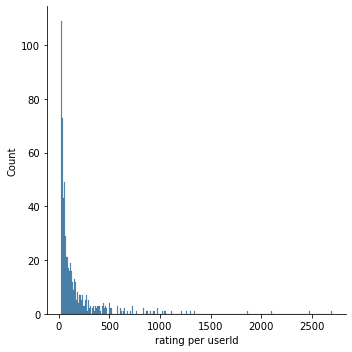

In [5]:
sns.displot(data=ratings_per_user, x=colName, binwidth=10)

#### 2. Ratings per movie

In [6]:
ratings_per_movie, colName = group_count_sort(ratings, 'movieId', 'rating')
stats(ratings_per_movie, colName);

Mean rating per movieId:  10.369806663924312
Median rating per movieId:  3.0


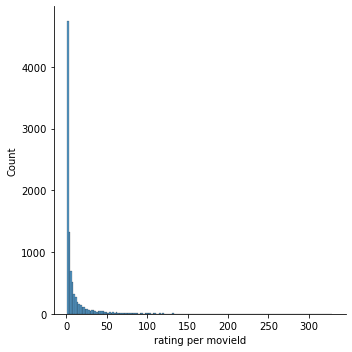

In [7]:
sns.displot(data=ratings_per_movie, x=colName, binwidth=2)

#### 3. Tags per movie

In [8]:
tags_per_movie, colName = group_count_sort(tags, 'movieId', 'tag')
stats(tags_per_movie, colName);

Mean tag per movieId:  2.3428753180661577
Median tag per movieId:  1.0


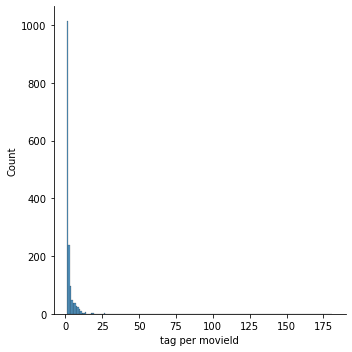

In [9]:
sns.displot(data=tags_per_movie, x=colName, binwidth=1)

Drop timestamp because it wil not be used and <b><i>complete data with useful meta data (director, date, cast, synopsis/keywords in synopsis)</i></b>

In [10]:
ratings = ratings.drop('timestamp', axis=1)


# II. Recommender Systems

>The data is very sparse, at 98% (0% if all users rated all movies). To deal with this, we could filter out users and movies with ratings below a threshold.
    
>The ones that don't make the cut will be recommended using a generalised recommendation based on overall well liked movie. These users will be considered as cold starts.

>Cold start movies will be recommended using a content based recommendation system (e.g. using director, genre, synopsis, cast). These could be mixed in with the recommendation of "well known" user.
   
>"Well known" users: Collaborative filtering   
Cold start items: Content based (director, genre, synopsis?, cast)  
Cold start users: Generalised recommendation  

Questions:
- Cold start threshold? for item? for user?

In [11]:
user_threshold = 50
movie_threshold = 15
filtered_users = ratings['userId'].value_counts()>=user_threshold
filtered_users = filtered_users[filtered_users].index.tolist()

filtered_movies = ratings['movieId'].value_counts()>=movie_threshold
filtered_movies = filtered_movies[filtered_movies].index.tolist()

filtered = ratings[(ratings['userId'].isin(filtered_users)) & (ratings['movieId'].isin(filtered_movies))]

print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(filtered.shape))

n_users = filtered['userId'].nunique()
n_movies = filtered['movieId'].nunique()
print('{} users and {} movies'.format(n_users, n_movies))
print('New sparsity: {:.2f}%'.format((1- filtered['userId'].count()/(n_users*n_movies))*100))

The original data frame shape:	(100836, 3)
The new data frame shape:	(67686, 3)
385 users and 1650 movies
New sparsity: 89.34%


### Testing
For now, we'll use 10% of the most rated movies to reduce the bias

In [12]:
filtered_movies = ratings.groupby('movieId').count().sort_values('userId', ascending=False)
filtered_movies = filtered_movies.head(int(filtered_movies.shape[0]*0.1+0.5)).index.tolist()


filtered = ratings[(ratings['userId'].isin(filtered_users)) & (ratings['movieId'].isin(filtered_movies))]

print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(filtered.shape))

n_users = filtered['userId'].nunique()
n_movies = filtered['movieId'].nunique()
print('{} users and {} movies'.format(n_users, n_movies))
print('New sparsity: {:.2f}%'.format((1- filtered['userId'].count()/(n_users*n_movies))*100))

The original data frame shape:	(100836, 3)
The new data frame shape:	(55016, 3)
385 users and 972 movies
New sparsity: 85.30%


What algorithm to use?   
- Test all algorithms in sci-kit surprise libarary using 10-fold cross validation
- Get the Root-mean-square deviation (RMSE) for each
And pick the one that seems the best (error values and speed)

In [13]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split
from surprise import Reader, Dataset, accuracy
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(filtered[['userId', 'movieId', 'rating']], reader)

In [25]:
benchmark = []
baseline = {'method': 'als',
               'n_epochs': 20,
               }
similarity = {'name': 'pearson'
               }
min_k = 10
max_k = 100
# Iterate over SVD, all KNN algorithms and
for algorithm in [KNNBaseline(k = max_k, k_min = min_k, sim_options = similarity, bsl_options = baseline, verbose=False), KNNBasic(k = max_k, k_min = min_k, sim_options = similarity, verbose=False), KNNWithMeans(k = max_k, k_min = min_k, sim_options = similarity, verbose=False), KNNWithZScore(k = max_k, k_min = min_k,verbose=False)]:
    print(algorithm)
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=10, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.822154,0.317780,0.442600
KNNWithMeans,0.829204,0.278563,0.345478
KNNWithZScore,0.836618,0.124078,0.402991
KNNBasic,0.909511,0.266870,0.317686


KNNBaseline has the lowest RMSE therefore we will be considering it as the best one to use

In [15]:
algo = KNNBaseline(verbose=False)
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False,n_jobs =-1)
results_df = pd.DataFrame(results).transpose()
results_df['mean'] = results_df.mean(numeric_only=True, axis=1)
results_df['var'] = results_df.var(numeric_only=True, axis=1)
results_df

,0,1,2,3,4,5,6,7,8,9,mean,var
test_rmse,0.818418,0.809016,0.838403,0.824239,0.836876,0.821991,0.822222,0.832709,0.828476,0.817119,0.824947,0.000077
test_mae,0.623667,0.622806,0.642166,0.628297,0.636859,0.622094,0.628329,0.633133,0.632507,0.624462,0.629432,0.000040
fit_time,0.198044,0.214048,0.203045,0.216048,0.204046,0.207046,0.196043,0.193040,0.171038,0.146033,0.194843,0.000408
test_time,0.672151,0.653147,0.601135,0.589133,0.593133,0.590132,0.587133,0.593133,0.577131,0.576131,0.603236,0.000949


In [16]:
algo = KNNBaseline(verbose=False)
algo = algo.fit(data.build_full_trainset())

def predict(userId):
    movies_df = ratings['movieId'].unique()
    pred = pd.DataFrame()
    
    for iid in movies_df:
        pred = pred.append({'movieId': iid, 'pred_rating':algo.predict(userId, iid)[3]}, ignore_index=True)
    return pred
    

In [46]:
user = 1
prediction = predict(user)
prediction = prediction.sort_values('movieId', ascending=False)
prediction.merge(movies, on= 'movieId')

,movieId,pred_rating,title,genres
0,193609.0,4.277932,Andrew Dice Clay: Dice Rules (1991),Comedy
1,193587.0,4.277932,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
2,193585.0,4.277932,Flint (2017),Drama
3,193583.0,4.277932,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
4,193581.0,4.277932,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
...,...,...,...,...
9719,5.0,3.605747,Father of the Bride Part II (1995),Comedy
9720,4.0,4.277932,Waiting to Exhale (1995),Comedy|Drama|Romance
9721,3.0,3.995015,Grumpier Old Men (1995),Comedy|Romance
9722,2.0,4.128038,Jumanji (1995),Adventure|Children|Fantasy


In [47]:
user_watched = ratings.loc[ratings['userId'] == user].merge(movies, on='movieId').sort_values('movieId', ascending=False)
user_watched

,userId,movieId,rating,title,genres
231,1,5060,5.0,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
230,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi
229,1,3809,4.0,What About Bob? (1991),Comedy
228,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
227,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
...,...,...,...,...,...
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance


Director  
Cast  
Keywords from synopsis  
Genre  
# Cold start recommendations (Only do if everything else done)

In [107]:
split_df = movies.copy().set_index('movieId')
def loadGenres(row):
    genres = row['genres'].split('|')
    for col in genres:
        if col not in split_df:
            split_df[col] = 0
        split_df.loc[int(row['movieId']), col] = 1
        

movies.apply(loadGenres, axis=1)
split_df = split_df.drop('genres', axis=1)
split_df = split_df.drop('title', axis=1)

Get weighted (by rating given) importances of each genre per user in percentages

In [109]:
genres = split_df.columns.tolist()
genres = [x for x in genres if x not in ['userId','movieId','rating']]

expanded_ratings = ratings.merge(split_df, on='movieId')
expanded_ratings[genres] = expanded_ratings[genres].multiply(expanded_ratings['rating'], axis=0)

expanded_ratings = expanded_ratings.drop(['movieId', 'rating'], axis=1)

expanded_ratings = expanded_ratings.groupby('userId').sum()

sum_df = expanded_ratings.sum(axis=1)
expanded_ratings[genres] = expanded_ratings[genres].multiply(1/sum_df, axis=0)
expanded_ratings = expanded_ratings.round(3)

expanded_ratings.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
userId,,,,,,,,,,,,,,,,,,,,
1,0.123,0.045,0.063,0.117,0.067,0.037,0.102,0.128,0.065,0.075,0.019,0.025,0.056,0.033,0.034,0.000,0.000,0.010,0.002,0.0
2,0.043,0.000,0.000,0.096,0.000,0.015,0.226,0.149,0.130,0.127,0.010,0.027,0.053,0.015,0.000,0.045,0.051,0.012,0.000,0.0
3,0.115,0.008,0.010,0.035,0.052,0.010,0.046,0.192,0.004,0.112,0.144,0.019,0.242,0.010,0.002,0.000,0.000,0.000,0.000,0.0
4,0.058,0.013,0.021,0.200,0.038,0.108,0.229,0.046,0.057,0.074,0.009,0.044,0.019,0.014,0.035,0.004,0.002,0.021,0.009,0.0
5,0.056,0.056,0.079,0.112,0.062,0.073,0.204,0.060,0.099,0.069,0.006,0.009,0.011,0.021,0.047,0.000,0.024,0.013,0.000,0.0


In [112]:
expanded_ratings.sort_values('Adventure', axis=0, ascending=False)

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
userId,,,,,,,,,,,,,,,,,,,,
531,0.258,0.000,0.014,0.069,0.055,0.028,0.092,0.180,0.041,0.101,0.041,0.000,0.092,0.000,0.014,0.000,0.000,0.014,0.000,0.000
556,0.236,0.022,0.058,0.028,0.229,0.031,0.058,0.108,0.000,0.032,0.017,0.026,0.037,0.000,0.020,0.000,0.098,0.000,0.000,0.000
291,0.224,0.051,0.054,0.035,0.130,0.019,0.062,0.126,0.018,0.041,0.000,0.027,0.078,0.008,0.000,0.000,0.126,0.000,0.000,0.000
248,0.223,0.050,0.044,0.081,0.051,0.014,0.023,0.212,0.017,0.059,0.000,0.014,0.165,0.000,0.000,0.006,0.033,0.000,0.000,0.007
106,0.212,0.016,0.039,0.053,0.172,0.010,0.075,0.156,0.019,0.054,0.013,0.034,0.045,0.000,0.000,0.000,0.100,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.004,0.004,0.018,0.211,0.028,0.077,0.250,0.028,0.028,0.113,0.007,0.099,0.007,0.035,0.028,0.000,0.000,0.028,0.035,0.000
175,0.000,0.000,0.054,0.214,0.000,0.246,0.387,0.000,0.000,0.006,0.003,0.000,0.010,0.000,0.080,0.000,0.000,0.000,0.000,0.000
547,0.000,0.000,0.000,0.125,0.052,0.130,0.250,0.057,0.057,0.109,0.000,0.047,0.052,0.042,0.016,0.036,0.000,0.000,0.026,0.000
